### Projectile

# Body Diagram

Using Newton's Second Law:

$ \sum \vec{F} = m \vec{a} $

- Friction:

	We need to define the behaviour of the friction force.
	Using an usual friction defined as:

	$$ \vec{F_f} = -\beta |\vec{v}| \vec{v} $$

	where $\beta$ is the friction coefficient and $\vec{v}$ the velocity.

- Equations of motion:

	$\vec r = (x, y)$

	Applying Newton's Second Law to the horizontal and vertical directions:
	$$ \vec{F_g} + \vec{F_f} = m \ddot{\vec{r}} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} + m \ddot{y} \hat{y} $$

	Separating the equations:

	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{y} \hat{y} $$

	Subsituting the friction force and the gravity force:
	$$ m \ddot{x} = -\beta |\vec{v}| \dot{x}  $$ 
	$$ m \ddot{y}  = -mg -\beta |\vec{v}| \dot{y}  $$

	Rearranging the equations and substituting r' = r/g (to use dimensionless units):
	$$ \ddot{x'} = -\frac{\beta g}{m} |\vec{v'}| \dot{x'} $$
	$$ \ddot{y'} = -1 -\frac{\beta g}{m} |\vec{v'}| \dot{y'} $$

We have 2 second order ODEs, we can separate them into 4 first order ODEs:
- $ \dot{x'} = v'_{x'} $
- $ \dot{y'} = v'_{y'} $
- $ \dot{v'_{x'}} = -\frac{\beta g}{m} |\vec{v'}| v'_{x'} $
- $ \dot{v'_{y'}} = -1 -\frac{\beta g}{m} |\vec{v'}| v'_{y'} $

	We can now apply the Runge-Kutta method to solve the ODEs. We will use the 4th order Runge-Kutta method. (Default in scipy.integrate.solve_ivp)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp

In [3]:
class Projectile():
	def __init__(self, r0, v0, thetas, t_span, B, m=9.81, g=9.81):
		"""
		Initializes a projectile object with initial position r0, initial velocity v0, time span t_span, air friction coeficient B and acceleration due to gravity g.
		"""
		self.t = t_span
		self.thetas = thetas
		self.x, self.y = r0
		self.v0 = v0
		self.vx, self.vy = v0*np.cos(thetas), v0*np.sin(thetas)

		self.B = B*g/m 
		self.S = [self.x, self.vx, self.y, self.vy]

	def solve_motion(self):
		"""
		Solves the motion of the projectile (with air resistance).
		"""
		def dSdt(t, S, B):
			"""
			Returns the time derivative of the state vector S.
			"""
			x, vx, y, vy = S
			return [vx, -B*vx, vy, -1 - B*vy]
		
		self.solutions = [solve_ivp(dSdt, self.t, [0, self.v0*np.cos(theta), 0, self.v0*np.sin(theta)], t_eval=np.linspace(*self.t, 100), args=(self.B,), dense_output=True) for theta in self.thetas]

	def peak(self):
		"""
		Returns the time, x and y coordinates of the peak of the projectile trajectory.
		"""
		return self.t[np.argmax(self.y)], self.x[np.argmax(self.y)], np.max(self.y)

In [20]:
# Initial conditions
r0 = (0, 0)
v = 1
thetas = np.linspace(0, np.pi/4, 10)
B = 1  # Air friction coeficient
t_span = (0, 5)

In [21]:
p = Projectile(r0, v, thetas, t_span, B, m=9.81, g=9.81)
p.solve_motion()

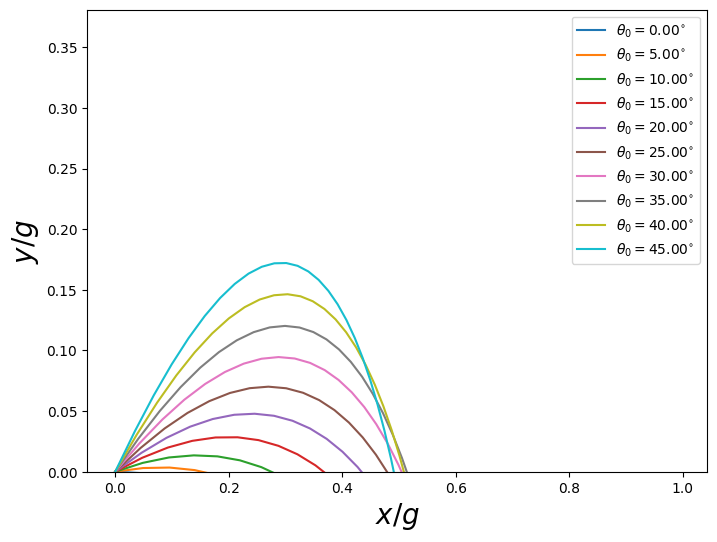

In [22]:
fig = plt.figure(figsize=(8, 6))
for sol in p.solutions:
	plt.plot(sol.y[0], sol.y[2], label=r'$\theta_0={:.2f}^{{\circ}}$'.format(np.arctan(sol.y[3][0]/sol.y[1][0])*180/np.pi))
plt.ylim(bottom=0)
plt.legend()
plt.xlabel('$x/g$', fontsize=20)
plt.ylabel('$y/g$', fontsize=20)
plt.show()

In [ ]:
def friction_1(t, x, vx, y, vy, m, g, B):
    # B = b * g / m - b is the friction coeficient normalized
    return [-B*np.sqrt(vx**2+vy**2)*vx, -B*np.sqrt(vx**2+vy**2)*vy - 1]

def friction_2(t, x, vx, y, vy, m, g, B):
    # B = b * g / m - b is the friction coeficient normalized
    return [-B*vx, -B*vy - 1]